In [1]:
# Importing libraries 
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf

In [13]:
import pandas as pd
import time
from datetime import datetime
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType
import matplotlib.pyplot as plt


In [16]:
# Creating SparkSession by assigning cores
spark = SparkSession.builder.appName("Data Processing").config("spark.executor.instances", 2).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/18 17:55:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [18]:
# Recording the start time
start_time = time.time()  

In [19]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [20]:
# Yelp API implementation

def fetch_reviews(api_key, business_id, num_reviews):
    headers = {
        'Authorization': 'Bearer ' + api_key,
    }
    url = 'https://api.yelp.com/v3/businesses/' + business_id + '/reviews'
    params = {
        'limit': num_reviews,
    }
    response = requests.get(url, headers=headers, params=params)
    return response.json()

In [21]:
pip install yelpapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.7/121.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.2/123.2 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.0/157.0 kB 19.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [22]:
from pyspark.sql import SparkSession
from yelpapi import YelpAPI

In [23]:
# Initializing Yelp API client
api_key = 'J1eg6rIR_J_D6QlSLMDa23LIl-AUrnDMC06cjfxJd7x56_Zq5Nof3-toeQmc2QCDLCgpM7P6ofcTzrHyAfFrNFUJE0doTegUIof6k5UkeT8u_ubkdztNXwfZmQJYZHYx'
yelp_api = YelpAPI(api_key)

In [24]:
# Defining search parameters
params = {
    'location': 'Ireland',
    'term': 'restaurants',
    'limit': 50
}


In [25]:
# Retrieving search results
response = yelp_api.search_query(**params)

In [45]:
# Extracting relevant business data and Creating Spark DataFrame and loading the extracted data into it 
businesses = response['businesses']
business_data = [(b['name'], b['rating'], b['review_count'], b.get('price', ''), 
                  ','.join([c['title'] for c in b.get('categories', [])]),
                  ','.join([f"{k}: {v}" for k, v in b.get('attributes', {}).items()])) for b in businesses]
spark = SparkSession.builder.appName('Yelp Reviews').getOrCreate()
df = spark.createDataFrame(business_data, ['name', 'rating', 'review_count', 'price', 'categories', 'attributes'])


In [46]:
# Perform further analysis on DataFrame
df.show()

+--------------------+------+------------+-----+--------------------+----------+
|                name|rating|review_count|price|          categories|attributes|
+--------------------+------+------------+-----+--------------------+----------+
|     The Boxty House|   4.5|         992|   €€|               Irish|          |
|The Old Mill Rest...|   4.5|         148|   €€|   Seafood,Wine Bars|          |
|       The Pig's Ear|   4.5|         225|  €€€|Bistros,Modern Eu...|          |
|       Darkey Kellys|   4.5|         155|   €€|          Pubs,Irish|          |
|             P Mac's|   4.5|         181|   €€|     Pubs,Gastropubs|          |
|            Sheehans|   4.5|         101|   €€|Pubs,Irish,Irish Pub|          |
|                Klaw|   4.5|         172|   €€|             Seafood|          |
|         F.X.Buckley|   4.5|          87|  €€€|   Steakhouses,Irish|          |
|     The Brazen Head|   4.0|         766|   €€|Pubs,Irish,Music ...|          |
|   Elephant & Castle|   4.0

In [27]:
df.describe()

23/05/18 18:02:05 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


summary,name,rating,review_count,price,categories,attributes
count,50,50,50,50,50,50
mean,null,4.31,188.06,null,null,null
stddev,null,0.2837432009434459,189.34844351413213,null,null,null
min,Bar Italia ristor...,3.5,7,,"American (New),Ba...",
max,Zaytoon,5.0,992,€€€,"Wine Bars,Tapas/S...",


In [28]:
grouped_data = df.groupBy('categories').agg({'review_count': 'avg'})
grouped_data.show()

+--------------------+-----------------+
|          categories|avg(review_count)|
+--------------------+-----------------+
|               Irish|432.3333333333333|
|          Pubs,Irish|            155.0|
|Pubs,Irish,Irish Pub|            101.0|
|     Pubs,Gastropubs|            375.5|
|Bistros,Modern Eu...|            225.0|
|   Seafood,Wine Bars|            148.0|
|   Steakhouses,Irish|             87.0|
|             Italian|             52.5|
|American (Traditi...|            353.0|
|Pubs,Irish,Music ...|            569.5|
|             Seafood|            172.0|
|Street Vendors,Ch...|             30.0|
|Pubs,Sports Bars,...|            265.0|
|Tapas/Small Plate...|             32.0|
|         Steakhouses|            106.0|
|Irish,Modern Euro...|            149.0|
|                Thai|            126.0|
|Middle Eastern,Br...|            332.0|
| Seafood,Steakhouses|             31.0|
|Bakeries,Coffee &...|            262.0|
+--------------------+-----------------+
only showing top

In [29]:
grouped_data = df.groupBy('rating').agg({'review_count': 'avg'})
grouped_data.show()

+------+------------------+
|rating| avg(review_count)|
+------+------------------+
|   4.5|158.26666666666668|
|   4.0|241.38888888888889|
|   5.0|              30.0|
|   3.5|             280.0|
+------+------------------+



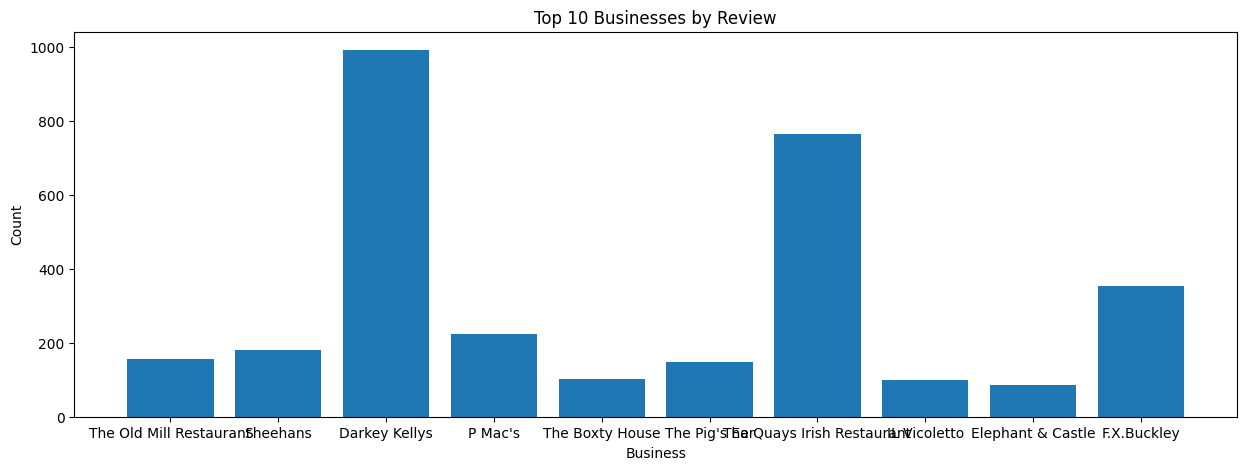

In [44]:
labels = [row['name'] for row in df.groupBy("name").count().orderBy('count', ascending=False).take(10)]
values = [row['review_count'] for row in df.groupBy("review_count").count().orderBy('count', ascending=True).take(10)]


plt.figure(figsize=(15, 5))
plt.bar(labels, values)
plt.title('Top 10 Businesses by Review')
plt.xlabel('Business')
plt.ylabel('Count')
plt.show()

In [47]:
#Measure the processing time
end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time} seconds")

Total time taken: 1151.2539989948273 seconds
